In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class PositionAttentionModule(nn.Module):
    ''' self-attention '''

    def __init__(self, in_channels):
        super().__init__()
        self.query_conv = nn.Conv1d(
            in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        inputs :
            x : feature maps from feature extractor. (N, C, H, W)
        outputs :
            feature maps weighted by attention along spatial dimensions
        """

        N, C, L = x.shape
        query = self.query_conv(x).view(
            N, -1, L).permute(0, 2, 1)  # (N, H*W, C')
        key = self.key_conv(x).view(N, -1, L)  # (N, C', H*W)

        # caluculate correlation
        energy = torch.bmm(query, key)    # (N, H*W, H*W)
        # spatial normalize
        attention = self.softmax(energy)

        value = self.value_conv(x).view(N, -1, L)    # (N, C, H*W)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(N, C, L)
        out = self.gamma*out + x
        return out

In [3]:
class ChannelAttentionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        inputs :
            x : feature maps from feature extractor. (N, C, H, W)
        outputs :
            feature maps weighted by attention along a channel dimension
        """

        N, C, L = x.shape
        query = x.view(N, C, -1)    # (N, C, H*W)
        key = x.view(N, C, -1).permute(0, 2, 1)    # (N, H*W, C)

        # calculate correlation
        energy = torch.bmm(query, key)    # (N, C, C)
        energy = torch.max(
            energy, -1, keepdim=True)[0].expand_as(energy) - energy
        attention = self.softmax(energy)

        value = x.view(N, C, -1)

        out = torch.bmm(attention, value)
        out = out.view(N, C, L)
        out = self.gamma*out + x
        return out

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [5]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)
        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv1d(64, 20, kernel_size=3, stride=1, padding=1, bias=False)

        self.pam = PositionAttentionModule(in_channels=64)
        self.cam = ChannelAttentionModule()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        attention_input = encoder_states
        attention_input = attention_input.transpose(0,1)
        attention_input = self.conv1(attention_input)
        
        pam_out = self.pam(attention_input)
        cam_out = self.cam(attention_input)
        context_vector = pam_out + cam_out
        
        context_vector = self.conv2(context_vector)
        context_vector = context_vector.transpose(0,1)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [6]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [8]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[-0.0740],
        [-0.0676],
        [-0.0828],
        [-0.0649],
        [-0.0727]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [11]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [12]:
df_for_training=df[feature_names].astype(float)

In [13]:
df_for_training.shape

(11524, 22)

In [14]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [15]:
trainX=[]
trainY=[]

In [16]:
n_future=1
n_past=20

In [17]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [18]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [19]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [20]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [21]:
data,label=random_shuffle(trainX,trainY)

In [22]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [24]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.18163907527923584
Epoch: 1 Loss: 0.029575008898973465
Epoch: 2 Loss: 0.12782181799411774
Epoch: 3 Loss: 0.11763894557952881
Epoch: 4 Loss: 0.12240789830684662
Epoch: 5 Loss: 0.03022945486009121
Epoch: 6 Loss: 0.05039725452661514
Epoch: 7 Loss: 0.14846667647361755
Epoch: 8 Loss: 0.18791404366493225
Epoch: 9 Loss: 0.06507977098226547
Epoch: 10 Loss: 0.09823305904865265
Epoch: 11 Loss: 0.06861328333616257
Epoch: 12 Loss: 0.03053152561187744
Epoch: 13 Loss: 0.034384410828351974
Epoch: 14 Loss: 0.07041751593351364
Epoch: 15 Loss: 0.030503198504447937
Epoch: 16 Loss: 0.08323585987091064
Epoch: 17 Loss: 0.02410893328487873
Epoch: 18 Loss: 0.036537475883960724
Epoch: 19 Loss: 0.04093151539564133
Epoch: 20 Loss: 0.047847770154476166
Epoch: 21 Loss: 0.03917473554611206
Epoch: 22 Loss: 0.02774185501039028
Epoch: 23 Loss: 0.046310726553201675
Epoch: 24 Loss: 0.020979568362236023
Epoch: 25 Loss: 0.056346818804740906
Epoch: 26 Loss: 0.015491599217057228
Epoch: 27 Loss: 0.03558982536

Epoch: 221 Loss: 0.01402874942868948
Epoch: 222 Loss: 0.008989923633635044
Epoch: 223 Loss: 0.012582610361278057
Epoch: 224 Loss: 0.03047732636332512
Epoch: 225 Loss: 0.020763840526342392
Epoch: 226 Loss: 0.014079198241233826
Epoch: 227 Loss: 0.0038520838133990765
Epoch: 228 Loss: 0.021001644432544708
Epoch: 229 Loss: 0.017681721597909927
Epoch: 230 Loss: 0.012799913063645363
Epoch: 231 Loss: 0.010494658723473549
Epoch: 232 Loss: 0.03266676887869835
Epoch: 233 Loss: 0.024443380534648895
Epoch: 234 Loss: 0.01030337531119585
Epoch: 235 Loss: 0.006510401144623756
Epoch: 236 Loss: 0.011008009314537048
Epoch: 237 Loss: 0.008936498314142227
Epoch: 238 Loss: 0.015235110186040401
Epoch: 239 Loss: 0.011670421808958054
Epoch: 240 Loss: 0.017821768298745155
Epoch: 241 Loss: 0.018214181065559387
Epoch: 242 Loss: 0.010062916204333305
Epoch: 243 Loss: 0.017122481018304825
Epoch: 244 Loss: 0.02125256508588791
Epoch: 245 Loss: 0.007885556668043137
Epoch: 246 Loss: 0.013884905725717545
Epoch: 247 Loss:

Epoch: 438 Loss: 0.023960385471582413
Epoch: 439 Loss: 0.01903299242258072
Epoch: 440 Loss: 0.01809062249958515
Epoch: 441 Loss: 0.011611659079790115
Epoch: 442 Loss: 0.019230535253882408
Epoch: 443 Loss: 0.015727009624242783
Epoch: 444 Loss: 0.004920731298625469
Epoch: 445 Loss: 0.007436747662723064
Epoch: 446 Loss: 0.0052230749279260635
Epoch: 447 Loss: 0.04498616233468056
Epoch: 448 Loss: 0.01423664391040802
Epoch: 449 Loss: 0.01309620589017868
Epoch: 450 Loss: 0.005058901384472847
Epoch: 451 Loss: 0.016489991918206215
Epoch: 452 Loss: 0.0498170480132103
Epoch: 453 Loss: 0.014190565794706345
Epoch: 454 Loss: 0.012241024523973465
Epoch: 455 Loss: 0.019933169707655907
Epoch: 456 Loss: 0.005986033473163843
Epoch: 457 Loss: 0.020449958741664886
Epoch: 458 Loss: 0.00624504778534174
Epoch: 459 Loss: 0.019323518499732018
Epoch: 460 Loss: 0.014392038807272911
Epoch: 461 Loss: 0.012806868180632591
Epoch: 462 Loss: 0.007615009322762489
Epoch: 463 Loss: 0.018152683973312378
Epoch: 464 Loss: 0.

Epoch: 655 Loss: 0.011705897748470306
Epoch: 656 Loss: 0.008567394688725471
Epoch: 657 Loss: 0.0042388248257339
Epoch: 658 Loss: 0.014898990280926228
Epoch: 659 Loss: 0.005726504139602184
Epoch: 660 Loss: 0.016244443133473396
Epoch: 661 Loss: 0.007323413155972958
Epoch: 662 Loss: 0.006477870978415012
Epoch: 663 Loss: 0.02154262363910675
Epoch: 664 Loss: 0.008859825320541859
Epoch: 665 Loss: 0.019688084721565247
Epoch: 666 Loss: 0.0061940997838974
Epoch: 667 Loss: 0.003930504433810711
Epoch: 668 Loss: 0.009602340869605541
Epoch: 669 Loss: 0.010931207798421383
Epoch: 670 Loss: 0.004724487662315369
Epoch: 671 Loss: 0.007179395295679569
Epoch: 672 Loss: 0.008845403790473938
Epoch: 673 Loss: 0.004815841093659401
Epoch: 674 Loss: 0.05392184108495712
Epoch: 675 Loss: 0.01135009340941906
Epoch: 676 Loss: 0.011967923492193222
Epoch: 677 Loss: 0.003451013006269932
Epoch: 678 Loss: 0.011027739383280277
Epoch: 679 Loss: 0.01876632682979107
Epoch: 680 Loss: 0.009528886526823044
Epoch: 681 Loss: 0.0

Epoch: 872 Loss: 0.012546674348413944
Epoch: 873 Loss: 0.0048599084839224815
Epoch: 874 Loss: 0.007305622100830078
Epoch: 875 Loss: 0.005546825937926769
Epoch: 876 Loss: 0.0027399295940995216
Epoch: 877 Loss: 0.012409737333655357
Epoch: 878 Loss: 0.06422223150730133
Epoch: 879 Loss: 0.007263738662004471
Epoch: 880 Loss: 0.010316193103790283
Epoch: 881 Loss: 0.009193540550768375
Epoch: 882 Loss: 0.008659455925226212
Epoch: 883 Loss: 0.008074384182691574
Epoch: 884 Loss: 0.008575395680963993
Epoch: 885 Loss: 0.014229006133973598
Epoch: 886 Loss: 0.01228301227092743
Epoch: 887 Loss: 0.011410627514123917
Epoch: 888 Loss: 0.011043468490242958
Epoch: 889 Loss: 0.01998208463191986
Epoch: 890 Loss: 0.008348658680915833
Epoch: 891 Loss: 0.01502455584704876
Epoch: 892 Loss: 0.010985396802425385
Epoch: 893 Loss: 0.01083301566541195
Epoch: 894 Loss: 0.004180717281997204
Epoch: 895 Loss: 0.0035983435809612274
Epoch: 896 Loss: 0.005460040643811226
Epoch: 897 Loss: 0.020804153755307198
Epoch: 898 Los

In [25]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [27]:
predictions = np.array(predictions)

In [28]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [29]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

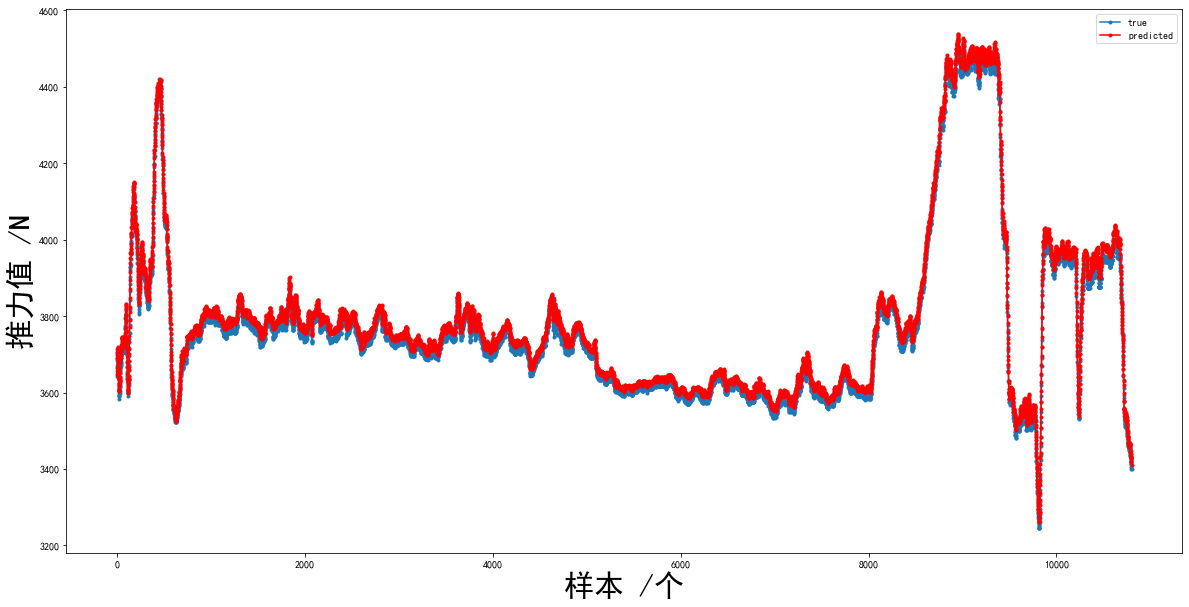

In [30]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();